In [2]:
import os
import json
import hashlib
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# configuración inicial, paths y carga de archivos
data_path = '../data' 
excel_files = sorted(glob.glob(os.path.join(data_path, 'Totalizadores*.xlsx')))

if not excel_files:
    print(f"No se encontraron archivos .xlsx en la carpeta: {data_path}")
else:
    print(f"Se encontraron {len(excel_files)} Archivos Excel encontrados y ordenados.")
    print([os.path.basename(f) for f in excel_files])

sheets_to_load = ['Consolidado EE', 'Consolidado Produccion', 'Consolidado GasVapor', 'Consolidado Agua']
timestamp_col_name = None
unified_sheets = {}


Se encontraron 3 Archivos Excel encontrados y ordenados.
['Totalizadores Planta - 2021_2023.xlsx', 'Totalizadores Planta 2020_2022.xlsx', 'Totalizadores Planta 2022_2023.xlsx']


In [4]:
# función que usamos para cargar y unificar las hojas de los archivos Excel, y eliminar duplicados
def load_and_unify_sheet(sheet_name, files):
    global timestamp_col_name
    data_frames = []
    print(f"Procesando hoja: '{sheet_name}'")
    
    for file in files:
        try:
            df_sheet = pd.read_excel(file, sheet_name=sheet_name)
            if timestamp_col_name is None:
                timestamp_col_name = df_sheet.columns[0]
                print(f"  > Columna de Timestamp: '{timestamp_col_name}'")
            data_frames.append(df_sheet)
        except Exception as e:
            print(f"  > Error al leer '{sheet_name}' de {os.path.basename(file)}: {e}")

    if data_frames:
        full_df = pd.concat(data_frames, ignore_index=True)
        # aca hacemos la limpieza de timestamps y eliminamos duplicados
        full_df[timestamp_col_name] = pd.to_datetime(full_df[timestamp_col_name], errors='coerce')
        full_df = full_df.dropna(subset=[timestamp_col_name])
        full_df = full_df.sort_values(by=timestamp_col_name)
        full_df = full_df.drop_duplicates(subset=[timestamp_col_name], keep='last')
        
        print(f"  > Hoja unificada. Filas horarias (sin duplicados): {full_df.shape[0]}")
        return full_df
    return pd.DataFrame()

In [5]:
# carga y unificación de las hojas necesarias
if excel_files:
    # cargamos las hojas necesarias
    for sheet in sheets_to_load:
        unified_sheets[sheet] = load_and_unify_sheet(sheet, excel_files)

    # nos aseguramos de que la hoja principal (EE) exista
    if 'Consolidado EE' not in unified_sheets or unified_sheets['Consolidado EE'].empty:
        print("\nNo se pudo cargar 'Consolidado EE'")
    else:
        # renombrar timestamp para el merge
        df_hourly_merged = unified_sheets['Consolidado EE'].rename(columns={timestamp_col_name: 'Timestamp'})
        
        # itermaos y unimos las otras hojas
        for sheet_name in sheets_to_load:
            if sheet_name == 'Consolidado EE':
                continue # Ya la tenemos
            
            if sheet_name in unified_sheets and not unified_sheets[sheet_name].empty:
                df_to_merge = unified_sheets[sheet_name].rename(columns={timestamp_col_name: 'Timestamp'})
                
                # renombramos las columnas para evitar conflictos
                suffix = f"_{sheet_name.split(' ')[-1]}" 
                
                merge_cols = {col: f"{col}{suffix}" for col in df_to_merge.columns if col != 'Timestamp'}
                df_to_merge = df_to_merge.rename(columns=merge_cols)
                
                # unimos
                df_hourly_merged = pd.merge(df_hourly_merged, df_to_merge, on='Timestamp', how='outer')
                print(f"\nMerge con '{sheet_name}' completado.")

        # calculamos el total diario filtrando la última hora del día
        df_hourly_merged = df_hourly_merged.sort_values(by='Timestamp')
        df_hourly_merged['fecha_dia'] = df_hourly_merged['Timestamp'].dt.date
        idx_last_hour = df_hourly_merged.groupby('fecha_dia')['Timestamp'].idxmax()
        
        df_daily_final = df_hourly_merged.loc[idx_last_hour].copy()
        
        # ordenamos el índice por fecha
        df_daily_final = df_daily_final.set_index(pd.to_datetime(df_daily_final['fecha_dia']))
        df_daily_final = df_daily_final.sort_index() 
        
        columns_to_drop = [col for col in ['Timestamp', 'fecha_dia', timestamp_col_name] if col in df_daily_final.columns]
        df_daily_final = df_daily_final.drop(columns=columns_to_drop)

        print(f"\nDataFrame DIARIO 'df_daily_final' creado en memoria.")
        print(f"Dimensiones : {df_daily_final.shape}")
        print("\nPrimeras 5 filas:")
        print(df_daily_final.head())
else:
    print("No se encontraron archivos Excel para procesar.")

Procesando hoja: 'Consolidado EE'
  > Columna de Timestamp: 'DIA'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado Produccion'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado GasVapor'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado Agua'
  > Hoja unificada. Filas horarias (sin duplicados): 1190

Merge con 'Consolidado Produccion' completado.

Merge con 'Consolidado GasVapor' completado.

Merge con 'Consolidado Agua' completado.

DataFrame DIARIO 'df_daily_final' creado en memoria.
Dimensiones : (1190, 80)

Primeras 5 filas:
                HORA  Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  Cocina (Kw)  \
fecha_dia                                                                       
2020-07-01  07:00:00      6875.62            649.25       827.75         26.0   
2020-07-02  06:00:00     13694.37            912.75      1067.50         95.0   
2020-07-03  06:00:00     1

In [6]:
# creación del archivo CSV con el DataFrame diario unificado

daily_csv_path = os.path.join(data_path, 'df_daily_unified.csv')

if 'df_daily_final' in locals() and not df_daily_final.empty:
    # guardar el DataFrame diario unificado 
    df_daily_final.to_csv(daily_csv_path, index=True)
    print(f"DataFrame diario guardado exitosamente en: {daily_csv_path}")
else:
    print(f"El DataFrame 'df_daily_final' no existe o está vacío.")

DataFrame diario guardado exitosamente en: ../data\df_daily_unified.csv


In [7]:
# checksum del DataFrame diario unificado
checksum_file_path = os.path.join(data_path, 'checksums.json')

try:
    # Calcular el hash MD5 del archivo
    with open(daily_csv_path, 'rb') as f:
        file_bytes = f.read()
        md5_hash = hashlib.md5(file_bytes).hexdigest()

    checksum_data = {
        "df_daily_unified": {
            "file": daily_csv_path,
            "hash_md5": md5_hash,
            "timestamp": pd.Timestamp.now().isoformat()
        }
    }
    
    # Guardar el JSON
    with open(checksum_file_path, 'w') as f:
        json.dump(checksum_data, f, indent=4)

    print(f"-Checksum")
    print(f"Hash MD5 del DataFrame diario: {md5_hash}")
    print(f"Checksum guardado en: {checksum_file_path}")

except FileNotFoundError:
    print(f"No se encontró el archivo {daily_csv_path}.")

-Checksum
Hash MD5 del DataFrame diario: 4422333d485a8dfd5ad6e89bd242f8e4
Checksum guardado en: ../data\checksums.json


### Análisis Temporal

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

sns.set_theme(style="whitegrid")
# creamos un DataFrame temporal para los gráficos
if 'df_daily_final' in locals() and not df_daily_final.empty:
    df_plot = df_daily_final.copy()

    # creamos variables temporales desde el índice
    df_plot['año'] = df_plot.index.year
    df_plot['mes_num'] = df_plot.index.month
    df_plot['mes_nombre'] = df_plot.index.month_name()
    df_plot['dia_semana'] = df_plot.index.day_name()

    # ordenamos los días de la semana y meses para los gráficos
    week_days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df_plot['dia_semana'] = pd.Categorical(df_plot['dia_semana'], categories=week_days_order, ordered=True)

    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df_plot['mes_nombre'] = pd.Categorical(df_plot['mes_nombre'], categories=month_order, ordered=True)

    print("Variables 'año', 'mes_nombre' y 'dia_semana' creadas para graficar.")
    print(df_plot[['Frio (Kw)', 'año', 'mes_nombre', 'dia_semana']].head())
else:
    print("El DataFrame 'df_daily_final' no se encontró.")

Variables 'año', 'mes_nombre' y 'dia_semana' creadas para graficar.
            Frio (Kw)   año mes_nombre dia_semana
fecha_dia                                        
2020-07-01     3545.0  2020       July  Wednesday
2020-07-02     4998.0  2020       July   Thursday
2020-07-03     6378.0  2020       July     Friday
2020-07-04     4602.0  2020       July   Saturday
2020-07-05     4914.0  2020       July     Sunday


In [9]:
# usamos un df auxiliar para graficar sin el outlier 
max_value = df_plot['Frio (Kw)'].quantile(0.99)
max_date = df_plot['Frio (Kw)'].idxmax()
print(f"Valor máximo de 'Frio (Kw)': {max_value} en la fecha {max_date}")

sane_threshold = 40000

df_plot_sane = df_plot[df_plot['Frio (Kw)'] < sane_threshold].copy()

Valor máximo de 'Frio (Kw)': 32690.929999999982 en la fecha 2021-08-25 00:00:00


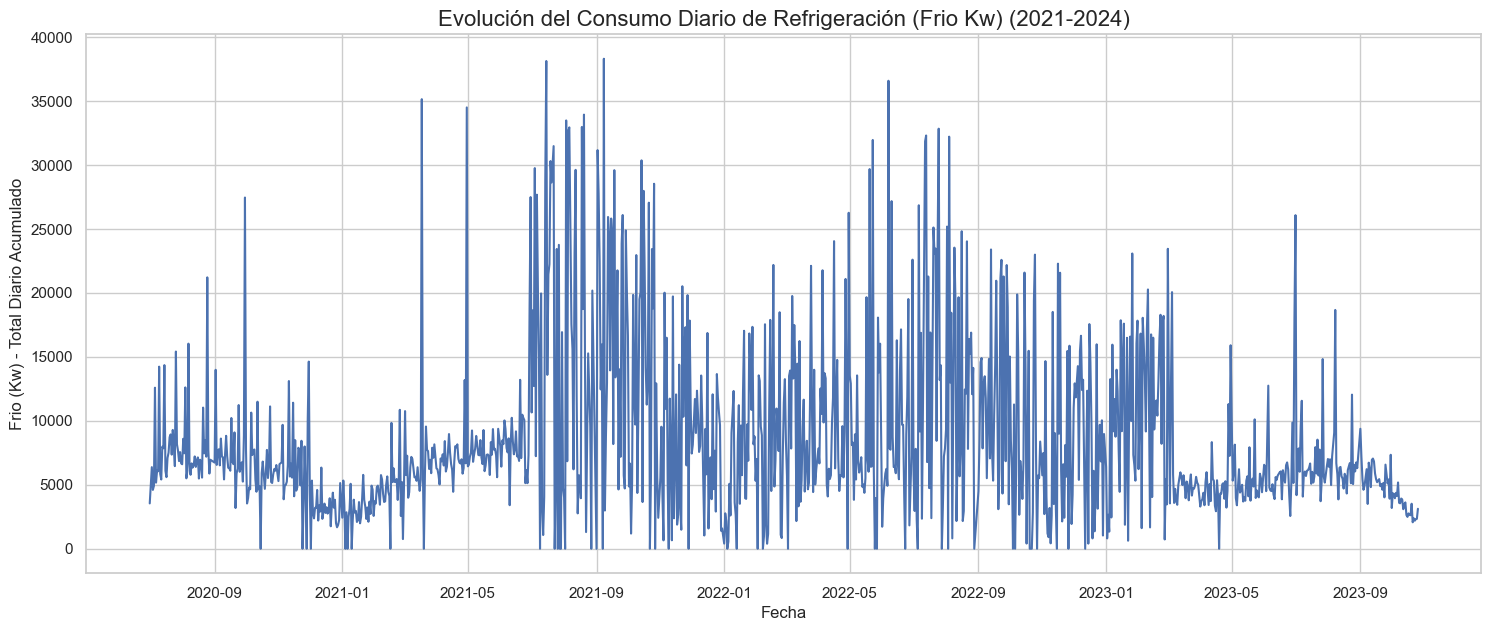

In [10]:
# Gráfico de la evolución temporal de 'Frio (Kw)'
if 'df_plot' in locals():
    plt.figure(figsize=(18, 7)) 

    # Graficamos 'Frio (Kw)' contra el índice (la fecha)
    sns.lineplot(data=df_plot_sane, x=df_plot_sane.index, y='Frio (Kw)')

    plt.title('Evolución del Consumo Diario de Refrigeración (Frio Kw) (2021-2024)', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Frio (Kw) - Total Diario Acumulado')
    plt.show() 
else:
    print("El DataFrame 'df_plot' no existe.")

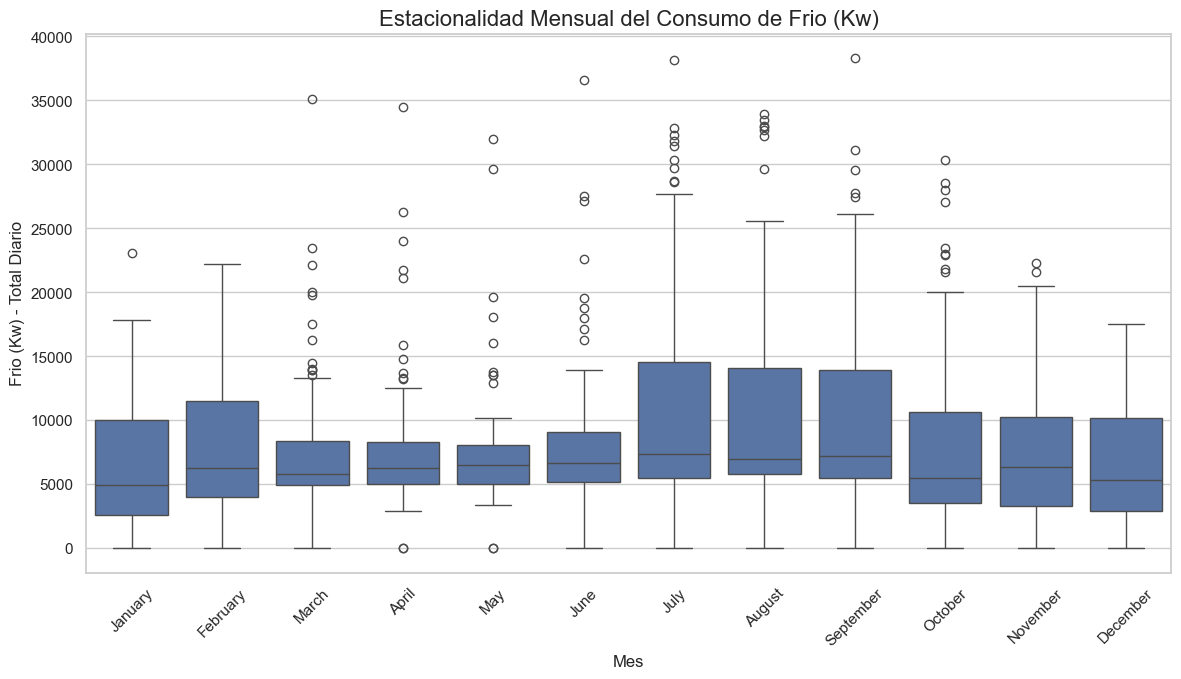

In [11]:
# Gráfico Boxplot Mensual de Estacionalidad de 'Frio (Kw)'

if 'df_plot' in locals():
    plt.figure(figsize=(14, 7))

    # boxplot de Frio (Kw) agrupado por mes
    sns.boxplot(data=df_plot_sane, x='mes_nombre', y='Frio (Kw)')

    plt.title('Estacionalidad Mensual del Consumo de Frio (Kw)', fontsize=16)
    plt.xlabel('Mes')
    plt.ylabel('Frio (Kw) - Total Diario')
    plt.xticks(rotation=45) # Rotamos las etiquetas de los meses
    plt.show()
else:
    print("El DataFrame 'df_plot' no existe.")

###
    Podemos notar una fuerte estacionalidad ya que el consumo no es igual a lo largo del año. Se ve que el consugmo es claramente alto en los meses de Julio, Agosto y Septiembre, lo cual podria inferirse que se debe a que se encuentran en verano. Por otro lado, podemos ver que el consumo es más bajo y estable en meses como Enero, Mayo y Diciembre.
    También podemos notar que que no solo el consumo promedio es más alto en Verano, sino que también la variabilidad también parece ser mayor. Esto lo podemos notar en que las cajas en estos meses son más altas, lo que significa que el rango entre un dia normal-bajo y un dia normal-alto es mucho más amplio.
    Podemos también observar que hay diferentes outliers, ya que hay muchos días con consumo extremadamente alto y bajos durante el transcurso del año.
###

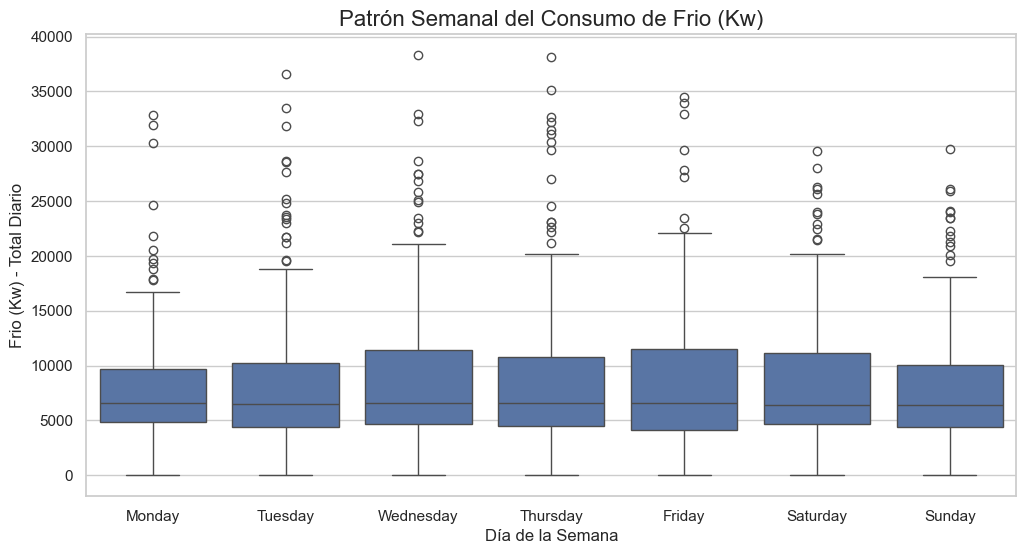

In [12]:
# Gráfico Boxplot Semanal de 'Frio (Kw)'

if 'df_plot' in locals():
    plt.figure(figsize=(12, 6))

    # boxplot de Frio (Kw) agrupado por día de la semana
    sns.boxplot(data=df_plot_sane, x='dia_semana', y='Frio (Kw)')

    plt.title('Patrón Semanal del Consumo de Frio (Kw)', fontsize=16)
    plt.xlabel('Día de la Semana')
    plt.ylabel('Frio (Kw) - Total Diario')
    plt.show()
else:
    print("El DataFrame 'df_plot' no existe.")


    Patrón Semanal:
        Podemos observar que durante el fin de semana hay un patrón difernte al resto de los días, sobretodo que existe un ciclo laboral o de producción muy definido. El Domingo, es el dia de menor actividad, ya qye el consumo se reduce. El Lunes lo podriamos ver como un día de arranque, ya que vemos que la actividad comienza a recuperarse pero aún no esta a pleno rendimiento. Mientras que de Martes a Sábado son los días de operación "normal", ya que el consumo es alto, establ y practicamente idéntico durante esos 5 dias.


In [15]:
## limpieza de errores y tipos de datos

if 'df_daily_final' in locals() and not df_daily_final.empty:
    # primero reemplazamos los errores comunes por NaN
    df_daily_final.replace(['#VALUE!', '#DIV/0!', '#N/A', '#NAME?'], np.nan, inplace=True)
    
    for col in df_daily_final.columns:
        # intentamos convertir a numérico
        df_daily_final[col] = pd.to_numeric(df_daily_final[col], errors='coerce')

    # valores faltantes
    missing_values_count = df_daily_final.isnull().sum()
    missing_values_percent = (missing_values_count / len(df_daily_final)) * 100 
    missing_df = pd.DataFrame({'Missing Values': missing_values_count, 'Percentage (%)': missing_values_percent})
    missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

    print(f"Se encontraron {len(missing_df)} columnas con valores faltantes.")
    print(missing_df.to_markdown(floatfmt=".4f"))
else:
    print("El DataFrame 'df_daily_final' no se encontró.")

Se encontraron 22 columnas con valores faltantes.
|                                   |   Missing Values |   Percentage (%) |
|:----------------------------------|-----------------:|-----------------:|
| HORA                              |        1190.0000 |         100.0000 |
| HORA_Produccion                   |        1190.0000 |         100.0000 |
| Unnamed: 14_Produccion            |        1190.0000 |         100.0000 |
| HORA_GasVapor                     |        1190.0000 |         100.0000 |
| HORA_Agua                         |        1190.0000 |         100.0000 |
| Unnamed: 15_Produccion            |        1148.0000 |          96.4706 |
| Unnamed: 18_Produccion            |        1148.0000 |          96.4706 |
| Unnamed: 16_Produccion            |        1148.0000 |          96.4706 |
| Unnamed: 17_Produccion            |        1148.0000 |          96.4706 |
| Vapor _Vapor_L5 (KG)_GasVapor     |         710.0000 |          59.6639 |
| Medicion Gas Planta (M3)_GasVapor | 

####
    Procedimos a detectar valores faltantes, de los cuales encontramos que hay 22 columnas que presentan datos faltantes y también buscamos los errores más comunes para reemplazarlo por un NaN, así tambien como forzamos la conversión de datos a valores numéricos
####

In [16]:
# análisis de correlaciones 

if 'df_daily_final' in locals():
    target_col = 'Frio (Kw)'
    
    # calculamos la matriz de correlación
    corr_matrix = df_daily_final.corr()
    
    # aislamos la correlación con el target
    corr_with_target = corr_matrix[target_col].abs().sort_values(ascending=False) # Usamos .abs() para encontrar las más correlacionadas (positiva o negativamente)

    # aca filtramos variables "trampa" (Data Leakage)
    # lista de columnas de 'Consolidado EE' (las que NO tienen sufijo)
    # estas miden el "efecto", no la "causa"
    ee_cols = [col for col in df_daily_final.columns if '_' not in col]
    
    # excluimos esas columnas de nuestra serie de correlaciones
    # usamos errors='ignore' por si alguna ya fue quitada
    corr_causal = corr_with_target.drop(ee_cols, errors='ignore')
    
    # sacamos el target ya que tiene correlación 1.0
    if target_col in corr_causal.index:
         corr_causal = corr_causal.drop(target_col)
    
    print(f"Top 15 Variables casuales correlacionadas con '{target_col}'")
    print(corr_causal.head(15).to_markdown(floatfmt=".4f"))
    
    top_15_features = corr_causal.head(15).index.tolist()
    top_5_features = top_15_features[:5]
else:
    print("El dataset'df_daily_final' no encontrado.")

Top 15 Variables casuales correlacionadas con 'Frio (Kw)'
|                                   |   Frio (Kw) |
|:----------------------------------|------------:|
| Agua Cond Evaporativos_Agua       |      0.8776 |
| Medicion Gas Planta (M3)_GasVapor |      0.8131 |
| Agua Efluentes_Agua               |      0.7698 |
| Hl de Mosto Copia_Produccion      |      0.6723 |
| Agua Calderas_Agua                |      0.6567 |
| Agua CO2_Agua                     |      0.6071 |
| Unnamed: 16_Produccion            |      0.3744 |
| Unnamed: 17_Produccion            |      0.3597 |
| Unnamed: 15_Produccion            |      0.3424 |
| Agua Paste L3_Agua                |      0.1522 |
| Vapor _Vapor_L5 (KG)_GasVapor     |      0.1263 |
| Agua Planta (Hl)_Agua             |      0.1082 |
| Vapor_L5 (KG)_GasVapor            |      0.1055 |
| Planta de agua (Hl)_Agua          |      0.1038 |
| Hl Cerveza Envasada_Produccion    |      0.1037 |


#### Aca hicimos un pequeño análisis de correlación para encontrar las 15 variables correlacionadas con nuestra variable objetivo

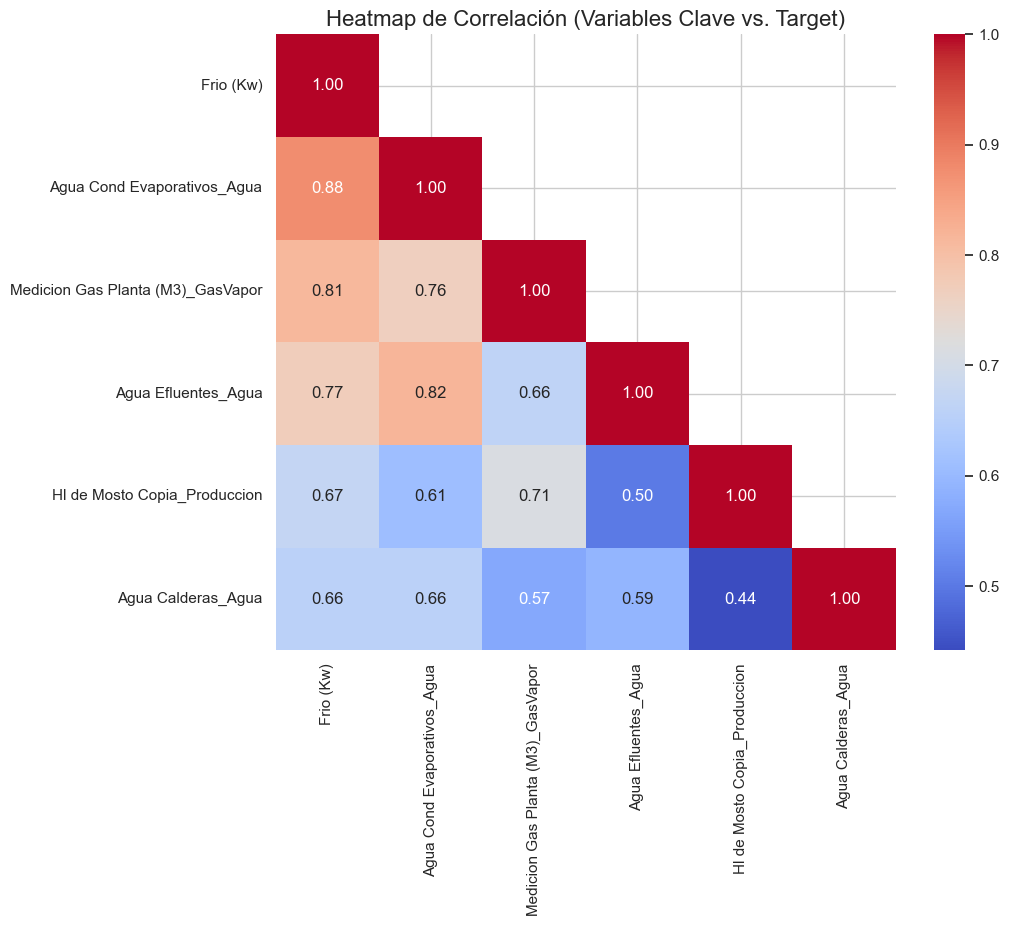

<Figure size 640x480 with 0 Axes>

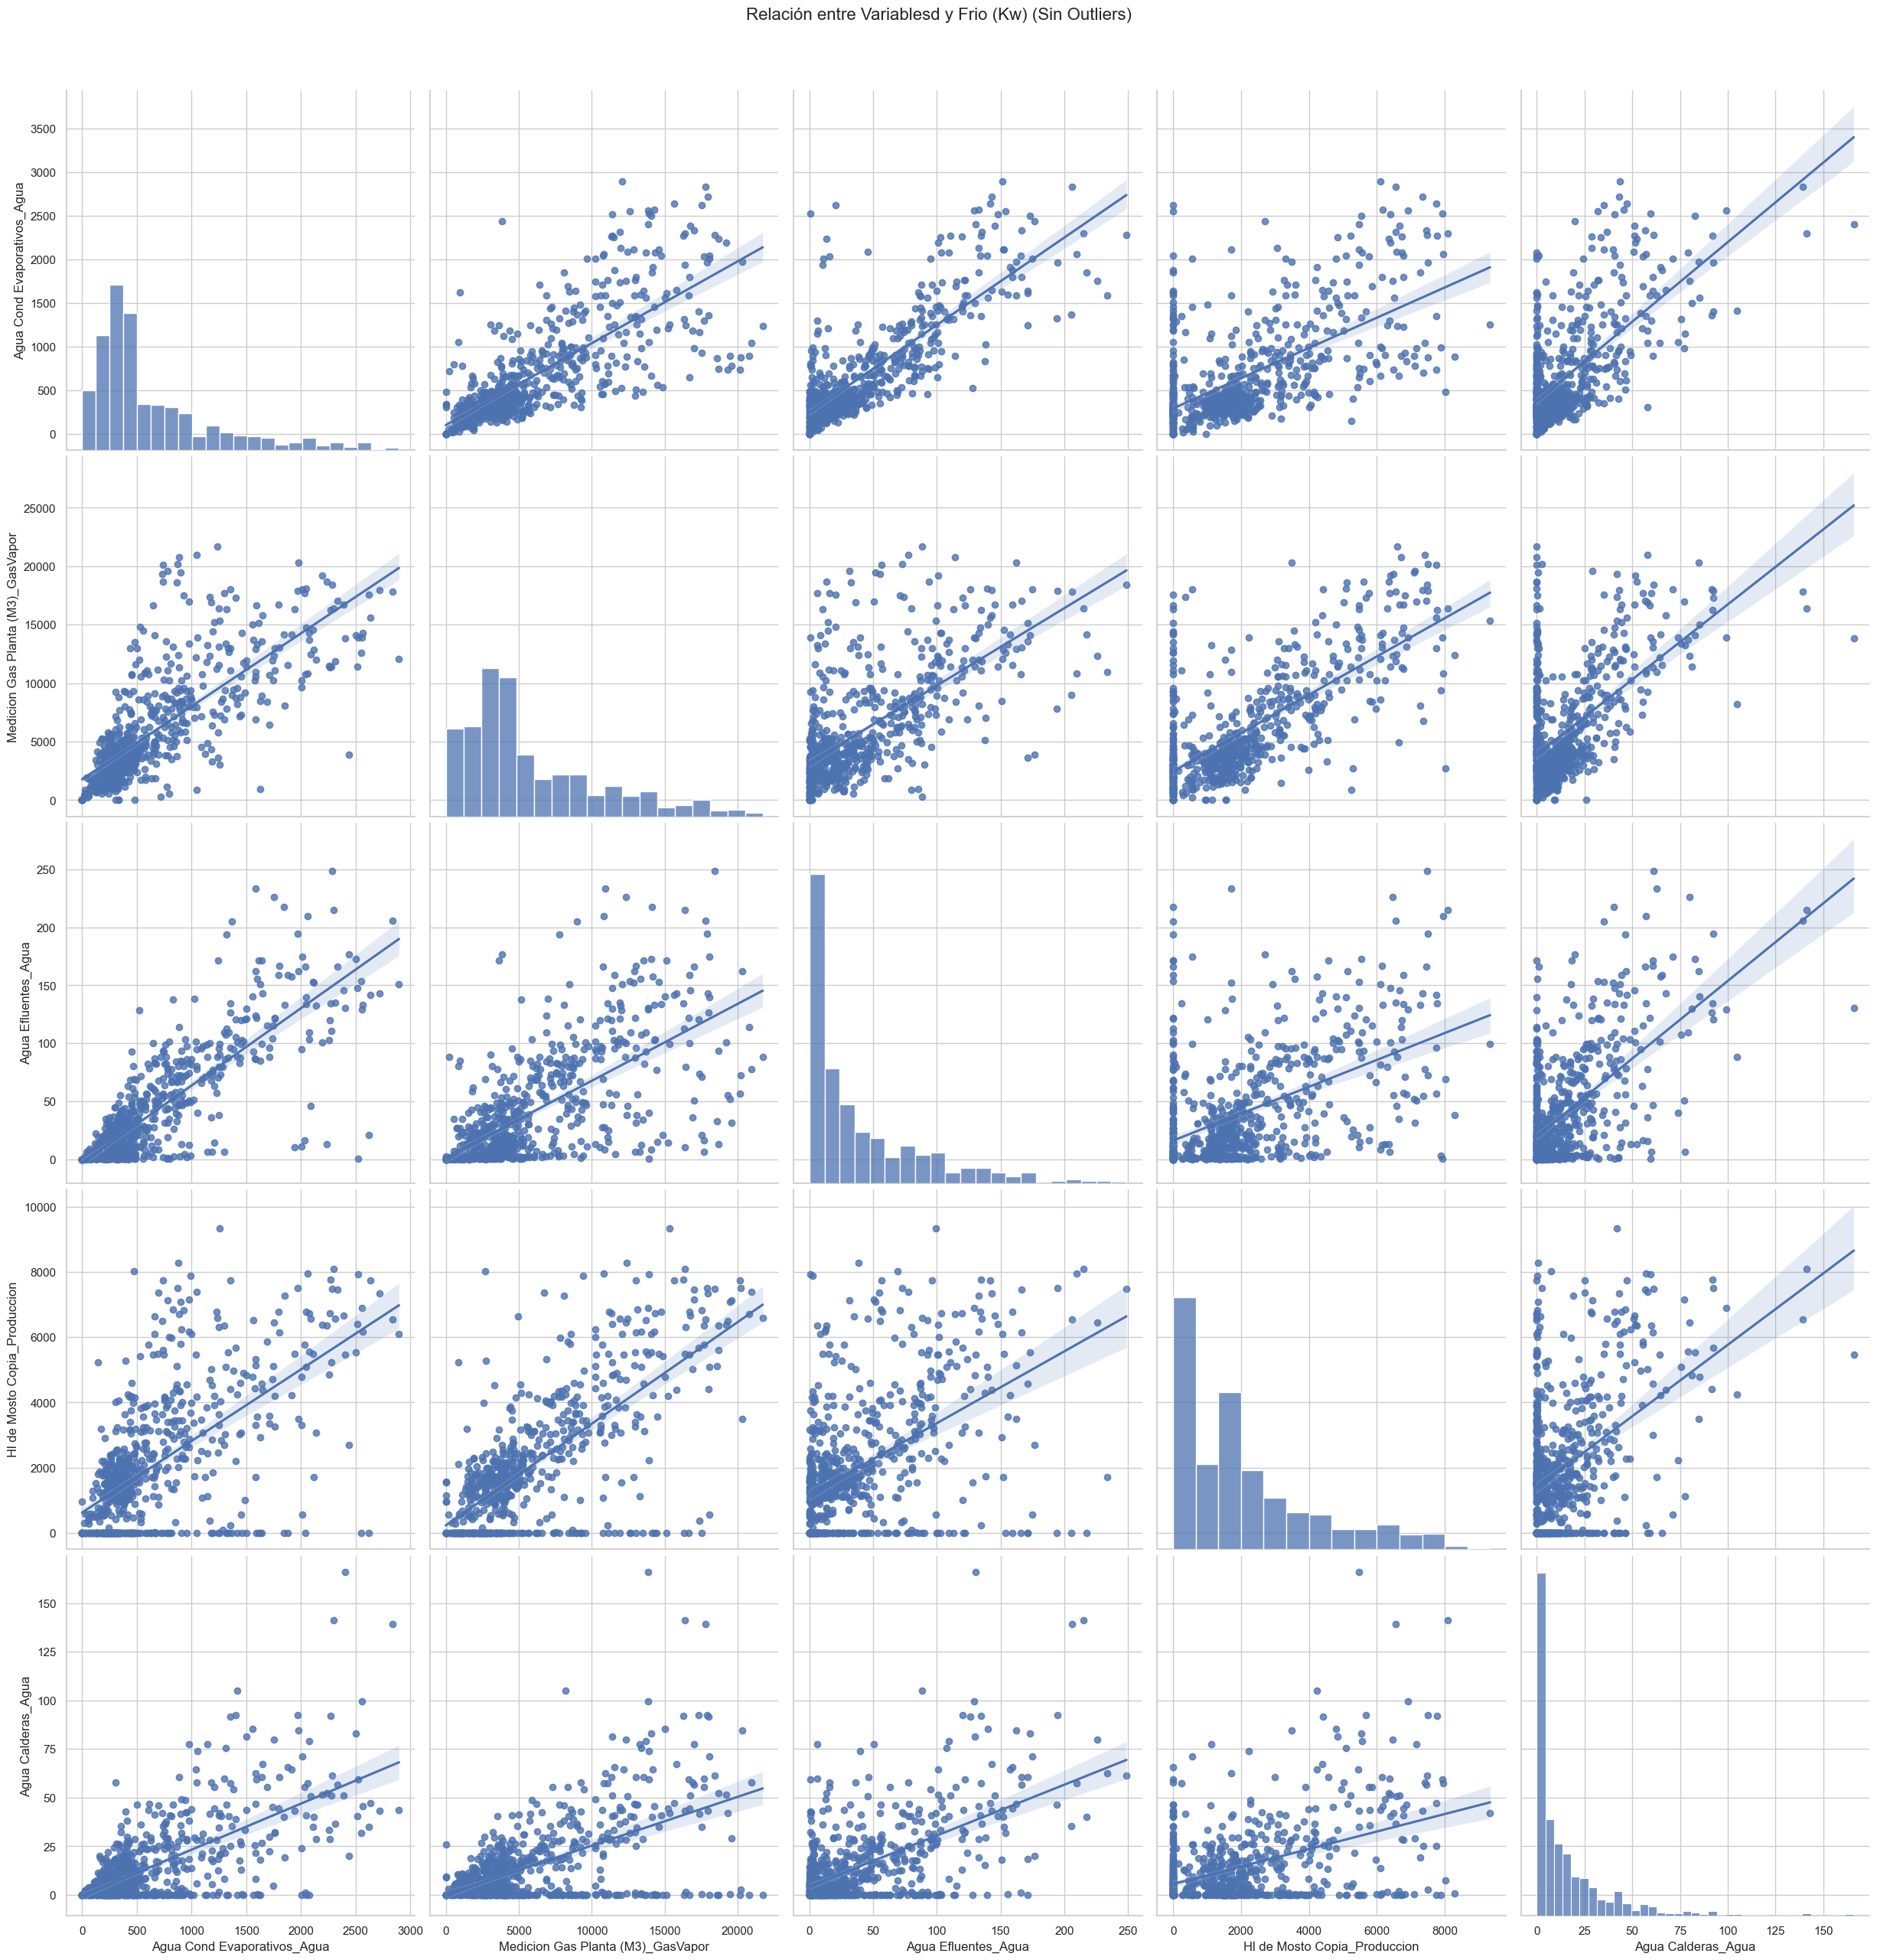

In [17]:
features_for_heatmap = [target_col] + top_5_features
features_for_scatter = top_5_features[:5]

if 'df_daily_final' in locals():
    # Calcula la correlación
    corr_subset = df_daily_final[features_for_heatmap].corr()
    
    # creamos una máscara para ocultar el triángulo superior
    # k=1 deja la diagonal principal visible
    mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_subset,
        mask=mask,       # aplicamosla máscara
        annot=True,
        fmt=".2f",
        cmap="coolwarm"
    )
    plt.title('Heatmap de Correlación (Variables Clave vs. Target)', fontsize=16)
    plt.show()
    plt.clf()

    # usamos el DataFrame sin los outliers (df_plot_sane)
    if 'df_plot_sane' in locals():
        pairplot_fig = sns.pairplot(
            data=df_plot_sane,
            vars=features_for_scatter, # Solo las 2 variables 
            y_vars=[target_col], 
            kind='reg', 
            height=5
        )
        pairplot_fig.fig.suptitle('Relación entre Variablesd y Frio (Kw) (Sin Outliers)', y=1.03, fontsize=16)
        plt.show()
    else:
        print("El dataframe 'df_plot_sane' no se ha encontrado.")
        
else:
    print("El dataframe'df_daily_final' no encontrado.")

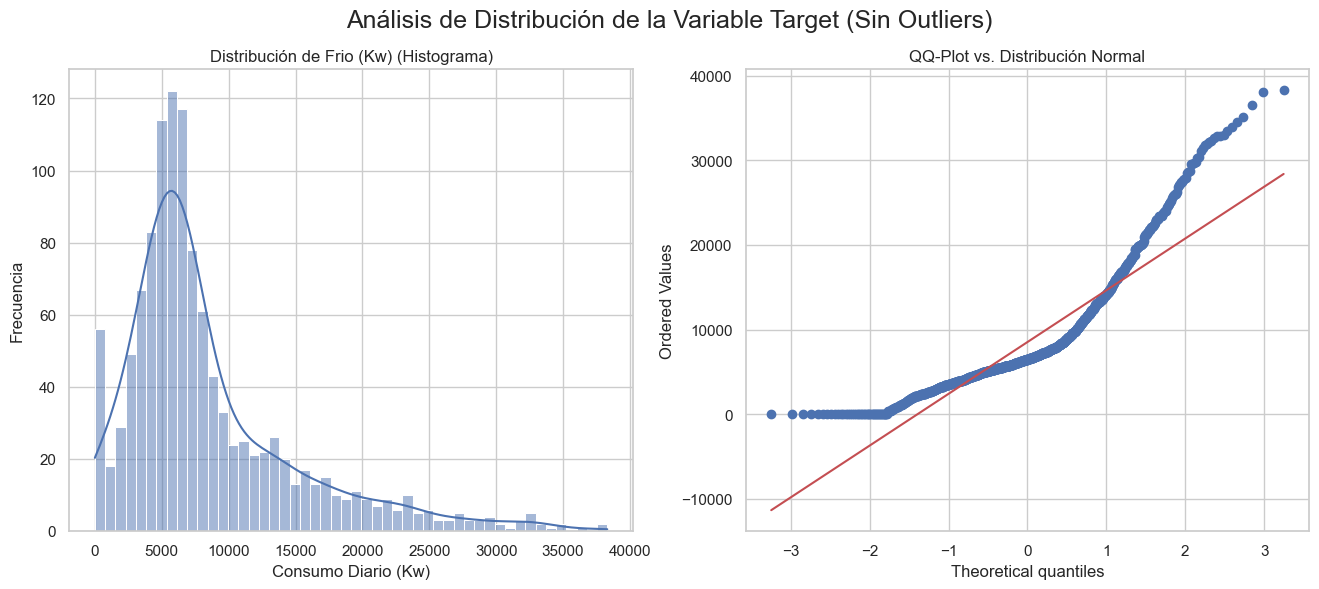

In [18]:
import scipy.stats as stats

# distribución del target (sin outliers)

if 'df_plot_sane' in locals():
    # Crear una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Histograma + KDE (Kernel Density Estimation)
    # Usamos el df_plot_sane para una mejor visualización
    sns.histplot(df_plot_sane[target_col], kde=True, ax=ax1, bins=50)
    ax1.set_title(f'Distribución de {target_col} (Histograma)')
    ax1.set_xlabel('Consumo Diario (Kw)')
    ax1.set_ylabel('Frecuencia')

    # 2. QQ-plot
    # También sobre los datos filtrados para ver la distribución "real"
    stats.probplot(df_plot_sane[target_col].dropna(), dist="norm", plot=ax2)
    ax2.set_title('QQ-Plot vs. Distribución Normal')

    fig.suptitle('Análisis de Distribución de la Variable Target (Sin Outliers)', fontsize=18)
    plt.show()
else:
    print("El dataframe 'df_plot_sane' no encontrado.")

###
    Histograma:
            Podemos observar que la distribución no es simétrica. Se ve que tiene una fuerte asimetría positiva o sesgo hacia la derecha, esto significa que la gran mayoría de los dias, el consumo es bajo o moderado (por lo que el pico alto está a la izquierda, entre 5000Kw - 10.000Kw). De la misma manera, podemos observar la "cola larga" hacia la derecha, lo que implica que existen pocos dias con cosumos muy altos (que pasan los 30.000Kw hasta los 40.000Kw).
    
    Q-Q Plot:
            Podemos observar que los puntos azules no siguen perfectamente la linea roja. Así también podemos ver que en los   valores bajos los puntos están por encima de la línea, indicando una "cola" más ligera que la normal, lo cuál es lógico debido a que el consumo no puede ser negativo. Y por otro lado, en los valores altos, los puntos se curvan y se alejan hacia arriba de la línea roja, confirmando asi una asimetría positiva (la cual se confirma en el histograma).
###